# Multi-Class Prediction of Obesity Risk


## Processo de desenvolvimento do modelo


## Preparação do ambiente e dos dados


### Imports e Configurações Gerais


In [290]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from itertools import product
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    cross_val_predict,
    cross_validate,
    train_test_split
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

# seaborn.set_theme()

### Funções


#### show_stats ( )


In [188]:
def show_stats(dataframe):
    """
    Retorna dataframe contendo a contagem de valores inválidos (None, NaN, NaT) em cada coluna do dataframe passado como parâmetro.
    """

    data_dict = {
        c: [
            dataframe.columns[c],
            (dataframe.shape[0] - dataframe[dataframe.columns[c]].count()),
            len(dataframe[dataframe.columns[c]].unique()),
            dataframe[dataframe.columns[c]].dtype,
        ]
        for c in range(len(dataframe.columns))
    }

    return pd.DataFrame(
        data=data_dict, index=["Nome", "Val. inválidos", "Val. únicos", "Tipo"]
    ).T

### Carregamento dos Dados


In [189]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

## Análise Exploratória


### Visão Geral


Os dados estão todos completos, sem valores faltantes ou evidentemente inválidos (ex: NaN) em nenhuma coluna.

Há [Informações sobre o significado de cada coluna](https://www.kaggle.com/competitions/playground-series-s4e2/discussion/472516) em comentário no Kaggle.


In [190]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [191]:
show_stats(train)

,Nome,Val. inválidos,Val. únicos,Tipo
0,id,0,20758,int64
1,Gender,0,2,object
2,Age,0,1703,float64
3,Height,0,1833,float64
4,Weight,0,1979,float64
5,family_history_with_overweight,0,2,object
6,FAVC,0,2,object
7,FCVC,0,934,float64
8,NCP,0,689,float64
9,CAEC,0,4,object


In [192]:
binary_columns = ["Gender", "family_history_with_overweight", "FAVC", "SMOKE", "SCC"]
categorical_columns = ["CAEC", "CALC", "MTRANS", "NObeyesdad"]
numerical_columns = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

### Atributos categóricos


#### Gender


Pela característica do atributo (não ter uma ordem), certamente vamos utilizar o One Hot Encoding. Que neste caso será como um atributo binário porque por conta da opção drop="First" que será usada.


In [193]:
print(train.Gender.unique())
print(test.Gender.unique())

['Male' 'Female']
['Male' 'Female']


In [194]:
gender_options = ["Male", "Female"]

#### CALC


Para este atributo há uma ordem muito clara entre as classes, de maneira que podemos fazer ordinal encoding, mas também podemos fazer one hot encoding, que possui a vantagem de não atribuir uma escala às classes. Mas ambos os métodos podem ser testados.


In [195]:
print(train.CALC.unique())
print(test.CALC.unique())

['Sometimes' 'no' 'Frequently']
['Sometimes' 'no' 'Frequently' 'Always']


In [196]:
CALC_options = ["no", "Sometimes", "Frequently", "Always"]

#### MTRANS


Neste atributo podemos proceder de duas maneiras principais:

- Utilizar One Hot Encoding. Escolha que considero mais certeira por não atribuir ordem ou escala.
- Definir uma ordem e utilizar ordinal encoding. Neste caso podemos olhar o comportamento do atributo em relação ao target para validar a ordem escolhida para cada classe.


In [197]:
print(train.MTRANS.unique())
print(test.MTRANS.unique())

['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
['Public_Transportation' 'Automobile' 'Walking' 'Bike' 'Motorbike']


In [198]:
MTRANS_options = ["Walking", "Public_Transportation", "Bike", "Motorbike", "Automobile"]

#### NObeyesdad (Target)


Para este atributo será feito ordinal encoding, porque há uma ordem clara entre as classes e este é o target, portanto está é a técnica mais usual para que a saída do algoritmo possa ser numérica.


In [199]:
print(train.NObeyesdad.unique())

['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


In [200]:
target_order = [
    "Insufficient_Weight",
    "Normal_Weight",
    "Overweight_Level_I",
    "Overweight_Level_II",
    "Obesity_Type_I",
    "Obesity_Type_II",
    "Obesity_Type_III",
]

### Matriz de dispersão


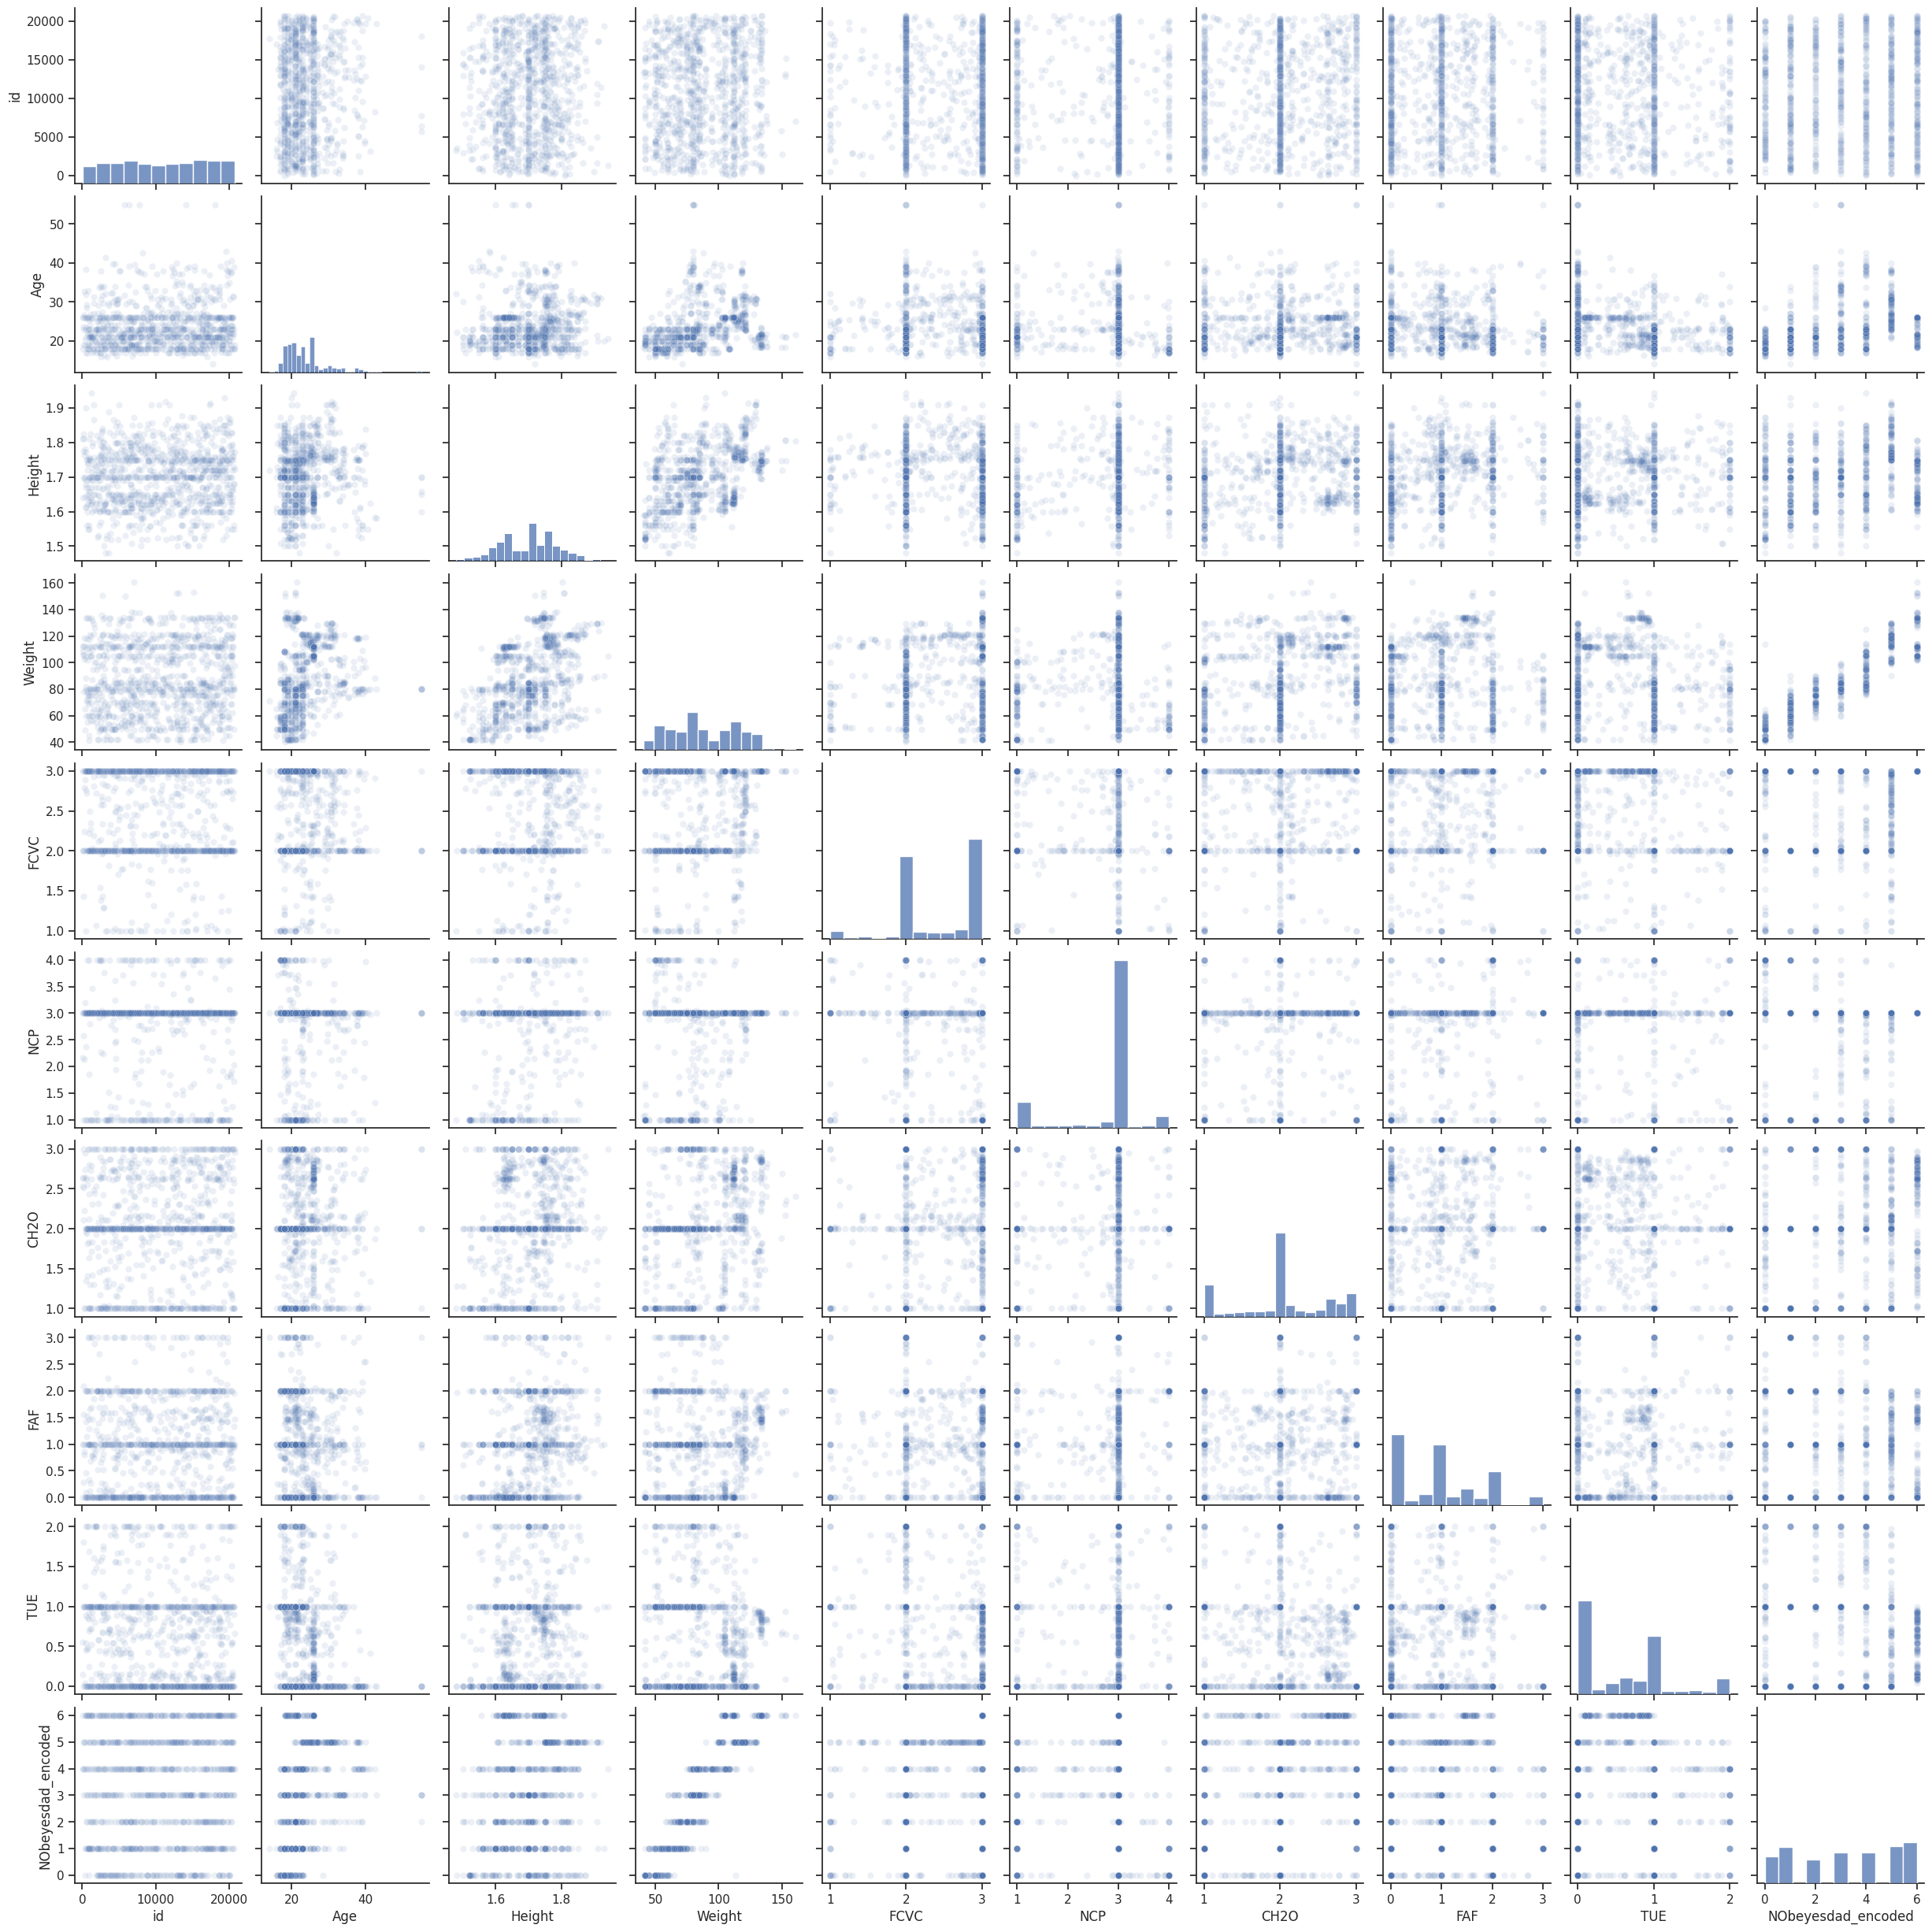

In [ ]:
sns.set_theme(style="ticks")
plot = sns.pairplot(train.sample(1000), plot_kws={'alpha':0.1})
# plot = sns.pairplot(train, plot_kw  s={'alpha':0.05})

## Comparação de modelos

### Separação das Labels


Vamos separar o dataset de maneira a ficar com o mesmo formato que teriam os dados reais com o modelo em produção, ou seja, sem o target.

Teremos um dataset apenas com as features e uma série apenas com os targets, ambos com mesma altura.

In [358]:
target_encoder = OrdinalEncoder(categories=[target_order], dtype=int)

train["NObeyesdad_encoded"] = target_encoder.fit_transform(
    train[["NObeyesdad"]]
).flatten()

features = train.drop(["NObeyesdad", "NObeyesdad_encoded"], axis=1)
target = train["NObeyesdad_encoded"]

### Modelos

A seguir são definidos os modelos que poderão ser usados no problema.

Conforme alguns modelos forem testados e não tiverem um bom desempenho poderão ser comentados para reduzir o tempo de processamento.

In [359]:
models = [
    # ("GNB", GaussianNB()),
    # ("DTR", DecisionTreeClassifier()),
    ("RFR", RandomForestClassifier()),
    # ("SVC", SVC()),
    # ("KNN", KNeighborsClassifier()),
]

A seguir é definido um dicionário que contém, como valores, listas de transformers excludentes nos entre si.

Ou seja, deve ser aplicado apenas um transformer de cada listas, assim podemos testar opções como usar one hot encoding ou label encoding em uma determinada coluna. 

Para algumas colunas (ou conjuntos de colunas) há apenas uma opção.

Novamente algumas opções poderão ser comentadas conforme se verifica o seu desempenho, mas sempre mantendo o registro para saber qual tratamento foi usado para cada resultado.

In [360]:
transformers = {
    "Numerical": [
        (
            "N1",
            "passthrough",
            numerical_columns,
        )
    ],
    "Gender": [
        (
            "G1",
            OneHotEncoder(
                categories=[gender_options], drop="first", sparse_output=False
            ),
            ["Gender"],
        ),
    ],
    "CALC": [
        (
            "C1",
            OneHotEncoder(categories=[CALC_options], drop="first", sparse_output=False),
            ["CALC"],
        ),
        ("C2", OrdinalEncoder(categories=[CALC_options], dtype=int), ["CALC"]),
    ],
    "MTRANS": [
        (
            "M1",
            OneHotEncoder(
                categories=[MTRANS_options], drop="first", sparse_output=False
            ),
            ["MTRANS"],
        ),
        ("M2", OrdinalEncoder(categories=[MTRANS_options], dtype=int), ["MTRANS"]),
    ],
}

Define um variável acumuladora de resultados se não estiver definida.

OBS: A variável acumulada pode sofrer problemas por conta de variações no formato dos dados com o tempo. Nesse caso pode ser necessário executar o bloco abaixo manualmente descomentando a primeira linha.

In [361]:
# accumulated_results = []

try:
    accumulated_results # type: ignore
except NameError:
    accumulated_results = []
else:
    pass

Calcula os Resultados para as permutações de pré-processamentos e modelos escolhidos.

Os resultados serão salvos em `results` e `results_df`, e também nas variáveis acumuladas.

In [362]:
results = []
results_df = pd.DataFrame()

for model, N, G, C, M in product(
    models, transformers["Numerical"], transformers["Gender"], transformers["CALC"], transformers["MTRANS"]
):
    print(".", end="")
    # print(model[0], N[0], G[0], C[0], M[0])

    pipeline = Pipeline(
        steps=[
            ("preprocessor", ColumnTransformer(transformers=[N, G, C, M])),
            model,
        ]
    )

    cv_results = cross_validate(
        pipeline,
        features,
        target,
        cv=5,
        # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy',
        return_train_score=True,
    )

    results.append({
        'Model': model[0],
        'Gender': G[0],
        'CALC': C[0],
        'MTRANS': M[0],
        'Mean Fit Time': cv_results['fit_time'].mean(),
        'Mean Test Accuracy': cv_results['test_score'].mean(),
        'Std Test Accuracy': cv_results['test_score'].std(),
        'Overfitting (%)': 100*(1 - cv_results['test_score'].mean()/cv_results['train_score'].mean()),
        'Support': 1, # Para contabilizar facilmente o Nº de testes com esta combinação
    })

results_df = pd.DataFrame(results)

accumulated_results += results
accumulated_results_df = pd.DataFrame(accumulated_results)

....

In [363]:
# results_df = pd.DataFrame(results)

# accumulated_results += results
# accumulated_results_df = pd.DataFrame(accumulated_results)

In [364]:
# display(results_df.round(3))

In [365]:
# Mostrar as médias agrupadas por modelo e pré-processamento
display(
    results_df.groupby(["Model", "Gender", "CALC", "MTRANS"])
    .mean()
    .sort_values("Mean Test Accuracy", ascending=False)
    .round(3)
)

Mean Fit Time  Mean Test Accuracy  \
Model Gender CALC MTRANS                                      
RFR   G1     C2   M2              1.998               0.893   
             C1   M1              1.778               0.892   
                  M2              1.610               0.891   
             C2   M1              1.566               0.889   

                          Std Test Accuracy  Overfitting (%)  Support  
Model Gender CALC MTRANS                                               
RFR   G1     C2   M2                  0.006           10.540      1.0  
             C1   M1                  0.006           10.632      1.0  
                  M2                  0.005           10.714      1.0  
             C2   M1                  0.006           10.987      1.0

Mostra os valores médios para cada combinação já testada, presentes na variável acumulada. As combinações são apresentadas em ordem decrescente de acurácia.

Também foi incluída uma coluna "Support", que mostra a quantidade de vezes a combinação foi testada.

In [366]:
# Mostrar as médias agrupadas por modelo e pré-processamento
display(
    accumulated_results_df.groupby(["Model", "Gender", "CALC", "MTRANS"])
    .agg(
        {
            "Mean Fit Time": "mean",
            "Mean Test Accuracy": "mean",
            "Std Test Accuracy": "mean",
            "Overfitting (%)": "mean",
            "Support": "sum",
        }
    )
    .sort_values("Mean Test Accuracy", ascending=False)
    .round(3)
)

Mean Fit Time  Mean Test Accuracy  \
Model Gender CALC MTRANS                                      
RFR   G1     C2   M2              1.891               0.892   
             C1   M1              1.768               0.892   
                  M2              1.607               0.891   
             C2   M1              1.627               0.890   
KNN   G1     C1   M1              0.027               0.843   
             C2   M1              0.051               0.843   
DTR   G1     C1   M2              0.100               0.843   
             C2   M2              0.096               0.842   
KNN   G1     C1   M2              0.059               0.842   
DTR   G1     C1   M1              0.113               0.841   
KNN   G1     C2   M2              0.050               0.841   
DTR   G1     C2   M1              0.100               0.840   
SVC   G1     C2   M2              4.392               0.711   
                  M1              4.424               0.709   
             C1   M2              4.977               0.708   
                  M1              4.198               0.708   
GNB   G1     C2   M2              0.024               0.700   
             C1   M2              0.031               0.690   
             C2   M1              0.027               0.668   
             C1   M1              0.059               0.652   

                          Std Test Accuracy  Overfitting (%)  Support  
Model Gender CALC MTRANS                                               
RFR   G1     C2   M2                  0.005           10.603        3  
             C1   M1                  0.005           10.679        3  
                  M2                  0.005           10.757        3  
             C2   M1                  0.006           10.876        3  
KNN   G1     C1   M1                  0.003            4.410        1  
             C2   M1                  0.004            4.514        1  
DTR   G1     C1   M2                  0.003           15.579        1  
             C2   M2                  0.003           15.608        1  
KNN   G1     C1   M2                  0.002            4.584        1  
DTR   G1     C1   M1                  0.002           15.752        1  
KNN   G1     C2   M2                  0.003            4.676        1  
DTR   G1     C2   M1                  0.004           15.830        1  
SVC   G1     C2   M2                  0.005            0.007        1  
                  M1                  0.004            0.063        1  
             C1   M2                  0.004            0.097        1  
                  M1                  0.004            0.085        1  
GNB   G1     C2   M2                  0.003            0.223        1  
             C1   M2                  0.006            0.219        1  
             C2   M1                  0.007            0.225        1  
             C1   M1                  0.008            0.433        1

## Construção do modelo principal

### Definição do modelo e preprocessamento

In [266]:
preprocessor = ColumnTransformer(
    transformers=[
        transformers["Numerical"][0],
        transformers["Gender"][0],
        transformers["CALC"][0],
        transformers["MTRANS"][0],
    ]
)

pipeline = Pipeline(steps=[("preprocessor", preprocessor), models[2]])

### Visualização detalhada do desempenho de um modelo (Playgroung)

#### Treino e teste (Substituída pela validação cruzada)


Esta seção foi mantida apenas para mostrar o progresso de desenvolvimento, mas todo o relatório de classificação feito aqui, foi refeito (e aprimorado) com validação cruzada, que dá mais confiabilidade a todas as métricas por calculá-las sobre todo o conjunto de dados.

In [267]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAcurácia do modelo: {accuracy:.3f}")

print("\nRelatório de Classificação:")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=target_order,
    )
)


Acurácia do modelo: 0.888

Relatório de Classificação:
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.91      0.92       524
      Normal_Weight       0.84      0.87      0.86       626
 Overweight_Level_I       0.76      0.73      0.74       484
Overweight_Level_II       0.76      0.78      0.77       514
     Obesity_Type_I       0.88      0.87      0.87       543
    Obesity_Type_II       0.97      0.97      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804

           accuracy                           0.89      4152
          macro avg       0.88      0.88      0.88      4152
       weighted avg       0.89      0.89      0.89      4152



#### Relatório de classificação detalhado 

Vamos obter predições para todo o conjunto de treino através de validação cruzada.

In [268]:
y_pred_cv = cross_val_predict(
    pipeline,
    features,
    target,
    cv=5,
    method="predict",
)

A seguir vemos um relatório geral de classificação para o modelo escolhido, que apresenta métricas de desempenho gerais e para cada uma das classes do atributo que queremos estimar.

In [269]:
print(f"\nAcurácia do modelo: {accuracy_score(target, y_pred_cv):.3f}")
print("\nRelatório de Classificação:")
print(classification_report(target, y_pred_cv, target_names=target_order))


Acurácia do modelo: 0.891

Relatório de Classificação:
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.93      0.92      2523
      Normal_Weight       0.85      0.87      0.86      3082
 Overweight_Level_I       0.77      0.72      0.74      2427
Overweight_Level_II       0.76      0.79      0.77      2522
     Obesity_Type_I       0.89      0.88      0.88      2910
    Obesity_Type_II       0.97      0.97      0.97      3248
   Obesity_Type_III       1.00      1.00      1.00      4046

           accuracy                           0.89     20758
          macro avg       0.88      0.88      0.88     20758
       weighted avg       0.89      0.89      0.89     20758



Para detalhar mais o comportamento que o modelo segue em cada uma das classes, a seguir apresentamos a matriz de confusão.

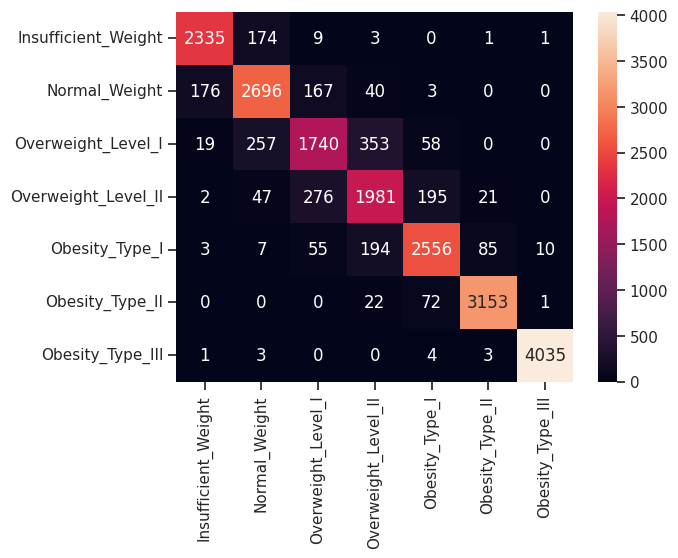

In [270]:
sns.heatmap(
    confusion_matrix(target, y_pred_cv),
    annot=True,
    fmt="d",
    xticklabels=target_order,
    yticklabels=target_order,
);

#### Comparação entre desempenho de treino e teste

In [271]:
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision_macro": make_scorer(precision_score, average="macro"),
    "recall_macro": make_scorer(recall_score, average="macro"),
    "f1_macro": make_scorer(f1_score, average="macro"),
}

cv_results = cross_validate(
    pipeline,
    features,
    target,
    cv=5,
    # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=scoring,
    return_train_score=True,
)

In [ ]:
# Cria um DataFrame com os resultados por fold
results_per_fold = pd.DataFrame(
    {
        # 'Fold': range(1, 6),
        "Acurácia (Treino)": cv_results["train_accuracy"],
        "Acurácia (Teste)": cv_results["test_accuracy"],
        "Precisão (Treino)": cv_results["train_precision_macro"],
        "Precisão (Teste)": cv_results["test_precision_macro"],
        "Recall (Treino)": cv_results["train_recall_macro"],
        "Recall (Teste)": cv_results["test_recall_macro"],
        "F1-Score (Treino)": cv_results["train_f1_macro"],
        "F1-Score (Teste)": cv_results["test_f1_macro"],
    }
)

# Adiciona médias ao final
results_per_fold.loc["Média"] = results_per_fold.mean()
results_per_fold.loc["Desvio Padrão"] = results_per_fold.std()

accuracy = results_per_fold.loc["Média"]["Acurácia (Teste)"]
test_relative_accuracy = (
    results_per_fold.loc["Média"]["Acurácia (Teste)"]
    / results_per_fold.loc["Média"]["Acurácia (Treino)"]
)

print(f"       Acurácia (Teste): {accuracy:.4f}")
print(f"Acurácia (Teste/Treino): {100*test_relative_accuracy:.2f}%")

print("\nMétricas por Fold, com Média e Desvio Padrão:")
display(results_per_fold.round(3))

       Acurácia (Teste): 0.8905
Acurácia (Teste/Treino): 89.21%

Métricas por Fold, com Média e Desvio Padrão:


,Acurácia (Treino),Acurácia (Teste),Precisão (Treino),Precisão (Teste),Recall (Treino),Recall (Teste),F1-Score (Treino),F1-Score (Teste)
0,0.998,0.889,0.998,0.877,0.998,0.876,0.998,0.876
1,0.998,0.886,0.998,0.873,0.998,0.872,0.998,0.872
2,0.998,0.898,0.998,0.887,0.998,0.886,0.998,0.886
3,0.998,0.892,0.998,0.880,0.998,0.879,0.998,0.879
4,0.998,0.888,0.998,0.876,0.998,0.876,0.998,0.875
Média,0.998,0.891,0.998,0.879,0.998,0.878,0.998,0.878
Desvio Padrão,0.000,0.004,0.000,0.005,0.000,0.005,0.000,0.005


## Predição e Submissão

### Predição

In [ ]:
pipeline.fit(features, target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE']),
                                                 ('Gender',
                                                  OneHotEncoder(categories=[['Male',
                                                                             'Female']],
                                                                drop='first',
                                                                sparse_output=False),
                                                  ['Gender']),
                                                 ('CALC',
                                                  OneHotEncoder(categories=[['no',
                                                                             'Sometimes',
                                                                             'Frequently',
                                                                             'Always']],
                                                                drop='first',
                                                                sparse_output=False),
                                                  ['CALC']),
                                                 ('MTRANS',
                                                  OneHotEncoder(categories=[['Walking',
                                                                             'Public_Transportation',
                                                                             'Bike',
                                                                             'Motorbike',
                                                                             'Automobile']],
                                                                drop='first',
                                                                sparse_output=False),
                                                  ['MTRANS'])])),
                ('model', SVC())])

In [ ]:
prediction = pipeline.predict(test)
predicted_classes = target_encoder.inverse_transform(
    prediction.reshape(-1, 1)
).flatten()

predicted_df = pd.DataFrame({"id": test.id, "NObeyesdad": predicted_classes})

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f"{timestamp}_submission.csv"

predicted_df.to_csv(f"../submission/{file_name}", index=False)

### Submissão

In [212]:
# os.system(f'kaggle competitions submit -f ../submission/{file_name} -m "Submitted by Jupyter notebook" "playground-series-s4e2"')